In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import tensorflow_hub as hub
import tensorflow_text
import warnings
from sentence_transformers import SentenceTransformer
warnings.filterwarnings('ignore')
from transformers import TFBertTokenizer, TFBertModel, BertTokenizer
import tqdm 
import unicodedata
import pickle
import re

In [2]:
with open('data_frame_object_with_all_embeddings', 'rb') as file:
    df = pickle.load(file)
print(df.shape)
df.head()

(150000, 7)


,title,body,label,full_text,distilbert-base-nli-mean-tokens_embeddings,albert-base-v1_embeddings,roberta-base-nli-stsb-mean-tokens_embeddings
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,title : y-zoom piano roll body : a y-zoom on t...,"[-0.7301139831542969, -0.047545962035655975, 0...","[0.0026986433658748865, 0.12280294299125671, -...","[0.42477285861968994, -0.09550482034683228, -0..."
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,title : buggy behavior in selection body : ! s...,"[-0.7117552757263184, 0.05117011442780495, 0.3...","[0.21210505068302155, -0.3419630825519562, -0....","[0.46860456466674805, -0.4723658561706543, 0.3..."
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"title : auto update feature body : hi,\r \r gr...","[-0.545153796672821, 0.023795893415808678, 0.9...","[0.07694720476865768, -0.23390068113803864, -0...","[0.7905717492103577, -0.6955427527427673, 0.66..."
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,title : filter out noisy endpoints in logs bod...,"[-0.5753872990608215, 0.24625295400619507, 0.5...","[0.14907507598400116, -0.36269834637641907, -0...","[0.34696999192237854, 0.3869624435901642, 0.26..."
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,title : enable pid on / pid off alarm actions ...,"[-0.600375771522522, -0.21507282555103302, 0.5...","[-0.005618194118142128, -0.010725936852395535,...","[0.36912062764167786, 0.15820196270942688, 0.1..."


In [9]:
def cleaner(text):
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text

def standardize_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
print(standardize_accented_chars(df['body'].loc[2]))

hi,\r \r great job so far, @saenzramiro ! : \r \r an auto update feature would be nice to have.\r or alternatively a menu button to check for the latest version manually.


In [11]:
def clean_text(text):
    text = re.sub(r'\r', ' ', text)
    text = re.sub(r'\\r', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@[\w]+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s.,!?]', '', text)
    return text

raw_text = "hi,\\r \\r great job so far, @saenzramiro ! : \\r \\r an auto update feature would be nice to have.\\r or alternatively a menu button to check for the latest version manually."
cleaned_text = clean_text(raw_text)
print(cleaned_text)

hi, great job so far,  !  an auto update feature would be nice to have. or alternatively a menu button to check for the latest version manually.


In [14]:
df['cleaned_body'] = df['body'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)
df['cleaned_full_text'] = 'title : ' + df['cleaned_title'] + ' body : ' + df['cleaned_body']
df.head()

,title,body,label,full_text,distilbert-base-nli-mean-tokens_embeddings,albert-base-v1_embeddings,roberta-base-nli-stsb-mean-tokens_embeddings,cleaned_body,cleaned_title,cleaned_full_text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,title : y-zoom piano roll body : a y-zoom on t...,"[-0.7301139831542969, -0.047545962035655975, 0...","[0.0026986433658748865, 0.12280294299125671, -...","[0.42477285861968994, -0.09550482034683228, -0...",a yzoom on the piano roll would be useful.,yzoom piano roll,title : yzoom piano roll body : a yzoom on the...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,title : buggy behavior in selection body : ! s...,"[-0.7117552757263184, 0.05117011442780495, 0.3...","[0.21210505068302155, -0.3419630825519562, -0....","[0.46860456466674805, -0.4723658561706543, 0.3...",! screenshot from 20160223 21 27 40,buggy behavior in selection,title : buggy behavior in selection body : ! s...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"title : auto update feature body : hi,\r \r gr...","[-0.545153796672821, 0.023795893415808678, 0.9...","[0.07694720476865768, -0.23390068113803864, -0...","[0.7905717492103577, -0.6955427527427673, 0.66...","hi, great job so far, ! an auto update featu...",auto update feature,"title : auto update feature body : hi, great j..."
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,title : filter out noisy endpoints in logs bod...,"[-0.5753872990608215, 0.24625295400619507, 0.5...","[0.14907507598400116, -0.36269834637641907, -0...","[0.34696999192237854, 0.3869624435901642, 0.26...",i think we should stop logging requests to he...,filter out noisy endpoints in logs,title : filter out noisy endpoints in logs bod...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,title : enable pid on / pid off alarm actions ...,"[-0.600375771522522, -0.21507282555103302, 0.5...","[-0.005618194118142128, -0.010725936852395535,...","[0.36912062764167786, 0.15820196270942688, 0.1...",expected behavior alarm actions pid on and pid...,enable pid on pid off alarm actions for ardui...,title : enable pid on pid off alarm actions f...


In [ ]:
### DO NOT RUN THIS CELL. IT takes 2 days to run.

# model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# def generate_embeddings(text):
#     embeddings = model.encode(text, convert_to_tensor=False)
#     return embeddings.tolist()
# # generate_embeddings('I am batman')
# df_train['distilbert-base-nli-mean-tokens_embeddings'] = df_train['full_text'].progress_map(generate_embeddings)

# model = SentenceTransformer('albert-base-v1')
# def generate_embeddings(text):
#     embeddings = model.encode(text, convert_to_tensor=False)
#     return embeddings.tolist()
# df_train['albert-base-v1_embeddings'] = df_train['full_text'].progress_map(generate_embeddings)

# model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
# def generate_embeddings(text):
#     embeddings = model.encode(text, convert_to_tensor=False)
#     return embeddings.tolist()
# df_train['roberta-base-nli-stsb-mean-tokens_embeddings'] = df_train['full_text'].progress_map(generate_embeddings)


# df_train.head()

It had taken a lot of time and computer power just to get the embeddings of all the 150000 rows and that is why I had to save my work as a pickle object. Our next task would be to apply different dimensionality reduction techniques and cluster them. 

Moreover, we will only visualize a subset of embeddings so that it can run on my machine. 

In [17]:
subset = df.sample(15000, random_state=42)
subset.head()

,title,body,label,full_text,distilbert-base-nli-mean-tokens_embeddings,albert-base-v1_embeddings,roberta-base-nli-stsb-mean-tokens_embeddings,cleaned_body,cleaned_title,cleaned_full_text
59770,install error at task gce-network : create ne...,i can't seem to get past this issue. when i ru...,0,title : install error at task gce-network : c...,"[0.17552486062049866, -0.6928068399429321, 0.5...","[-0.0004275469109416008, -0.4572095572948456, ...","[-0.06354925036430359, -0.24154216051101685, 0...",i cant seem to get past this issue. when i run...,install error at task gcenetwork create network,title : install error at task gcenetwork crea...
21362,feature request add remote url to images,here is the code:\r if image == nil \r ...,1,title : feature request add remote url to imag...,"[-1.217686653137207, 0.08400411158800125, 0.64...","[-0.16346250474452972, -0.33334043622016907, -...","[0.4955887496471405, -1.2017014026641846, -0.1...",here is the code if image nil nsurl url nsu...,feature request add remote url to images,title : feature request add remote url to imag...
127324,add backface culling option,add the option to enable/disable backface cull...,1,title : add backface culling option body : add...,"[-0.6306428909301758, 0.2176758348941803, 0.41...","[-0.06302886456251144, 0.24326874315738678, -0...","[0.24596714973449707, -0.4820990562438965, 0.5...",add the option to enabledisable backface culling.,add backface culling option,title : add backface culling option body : add...
140509,logo.png is overwritten in cloned animal,if an animal with an preexisting logo.png in...,0,title : logo.png is overwritten in cloned anim...,"[-0.03222042694687843, -0.44793790578842163, 0...","[-0.16925758123397827, -0.1644033044576645, -0...","[1.0833659172058105, -0.8279832005500793, -0.0...",if an animal with an preexisting logo.png in i...,logo.png is overwritten in cloned animal,title : logo.png is overwritten in cloned anim...
144297,marble != marble quark,i want marble stairs but my 12k marble apparen...,0,title : marble != marble quark body : i want ...,"[0.5874354839324951, -0.892536997795105, 0.645...","[0.017717327922582626, 0.013194145634770393, -...","[0.1952631175518036, 0.15871281921863556, -0.0...",i want marble stairs but my 12k marble apparen...,marble ! marble quark,title : marble ! marble quark body : i want ma...


# PCA

In [18]:
distil_bert_embed = np.array(subset['distilbert-base-nli-mean-tokens_embeddings'].tolist())
albert_embed = np.array(subset['albert-base-v1_embeddings'].tolist())
roberta_embed = np.array(subset['roberta-base-nli-stsb-mean-tokens_embeddings'].tolist())

In [28]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca_50 = PCA(n_components=50)  
pca_50_features = pca_50.fit_transform(distil_bert_embed)

# Perform t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
tsne_features = list(tsne.fit_transform(pca_50_features))

### DB Scan based clustering

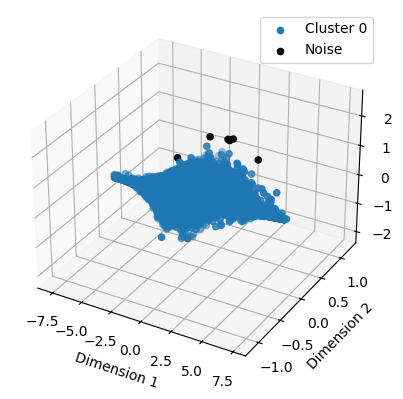

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust these hyperparameters
cluster = dbscan.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


### Agglomerative Hierarchical Clustering

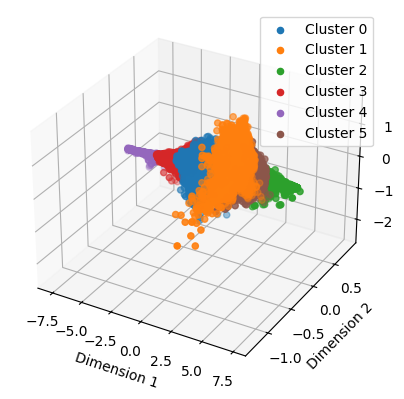

In [38]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=6)  # Set the number of clusters
cluster = agg_clustering.fit_predict(tsne_features)  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


## Spectral Clustering

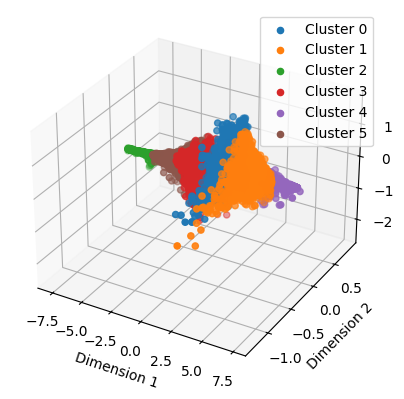

In [39]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=6)  # Set the number of clusters
cluster = spectral_clustering.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


## K Means clustering

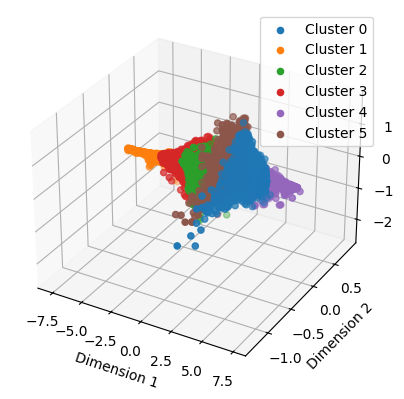

In [47]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
# Set the number of clusters
cluster = kmeans.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [40]:
def save_object(obj, path):
    import pickle
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
    
    
save_object(df, 'data_frame_object_with_all_embeddings_cleaned')

In [46]:
len(df['roberta-base-nli-stsb-mean-tokens_embeddings'].loc[0])

768